In [1]:
import pandas as pd
import numpy as np
from typing import Any
from tqdm import tqdm
from scipy.stats import linregress
from scipy.optimize import curve_fit
from scipy import odr
from scipy.stats import median_abs_deviation
import pickle
import os
import time
import seaborn as sns
sns.set_theme()

from utils import *

import matplotlib.pyplot as plt

LEVEL = 'member'  # 'member' or 'client'
N = 1
RECOMPUTE = True

column_positions = {'Trade Time': 3, 'ID Member': 1, 'Total Amount Buy': 9, 'Total Quantity Buy': 7, 'Total Amount Sell': 10, 'Total Quantity Sell': 8, 'ID Client': 0}


### Intro

Now I start to preprocess the dataframes

In [2]:
PATH_DATA_FOLDER = "C:/Users/User01/Documents/di_nosse/MOT"
PATH_NEW_DATA_FOLDER = "C:/Users/User01/Documents/di_nosse/MOT_NEW"

if os.path.exists(PATH_NEW_DATA_FOLDER) is False:
    os.mkdir(PATH_NEW_DATA_FOLDER)

dfs_paths = [PATH_DATA_FOLDER + '/' + path for path in os.listdir(PATH_DATA_FOLDER) if (path.endswith('.csv')) and (path != 'ALTRI_FTSEMIB.csv') and (path != 'MOT.csv')]
isins = [path.split('.')[0] for path in os.listdir(PATH_DATA_FOLDER) if (path.endswith('.csv')) and (path != 'ALTRI_FTSEMIB.csv') and (path != 'MOT.csv')]
print(dfs_paths)
print(isins)

['C:/Users/User01/Documents/di_nosse/MOT/IT0003934657.csv', 'C:/Users/User01/Documents/di_nosse/MOT/IT0005083057.csv', 'C:/Users/User01/Documents/di_nosse/MOT/IT0005217390.csv', 'C:/Users/User01/Documents/di_nosse/MOT/IT0005273013.csv', 'C:/Users/User01/Documents/di_nosse/MOT/IT0005358806.csv', 'C:/Users/User01/Documents/di_nosse/MOT/IT0005363111.csv', 'C:/Users/User01/Documents/di_nosse/MOT/IT0005425233.csv', 'C:/Users/User01/Documents/di_nosse/MOT/IT0005438004.csv', 'C:/Users/User01/Documents/di_nosse/MOT/IT0005441883.csv', 'C:/Users/User01/Documents/di_nosse/MOT/IT0005480980.csv', 'C:/Users/User01/Documents/di_nosse/MOT/IT0005496770.csv', 'C:/Users/User01/Documents/di_nosse/MOT/IT0005530032.csv', 'C:/Users/User01/Documents/di_nosse/MOT/IT0005534141.csv', 'C:/Users/User01/Documents/di_nosse/MOT/IT0005582421.csv', 'C:/Users/User01/Documents/di_nosse/MOT/IT0005583486.csv']
['IT0003934657', 'IT0005083057', 'IT0005217390', 'IT0005273013', 'IT0005358806', 'IT0005363111', 'IT0005425233', '

One of the original data sets

In [3]:
# df = pd.read_csv(dfs_paths[1], sep=';')
# df

Transform the original datasets

In [4]:
# for path in dfs_paths:
#     new_path = PATH_NEW_DATA_FOLDER + '/' + os.path.basename(path).split('.')[0] + '.parquet'
#     if os.path.exists(new_path):
#         print(f"Transformed file for {new_path} already exists. Skipping...")
#         continue
#     print(f"Processing {path}...")
#     df = pd.read_csv(path, sep=';')
#     df_mapped = map_trade_codes(df)
#     df_transformed = build_trades_view(df_mapped)
#     if len(df_transformed[(df_transformed['Total Quantity Buy'] > 0) & (df_transformed['Total Quantity Sell'] > 0)]) > 0:
#         print(f"Warning: Both Buy and Sell quantities greater than zero found in {path}. Check data integrity.")
#     # display(df_transformed)
#     df_transformed.to_parquet(new_path)
#     print(f"Saved transformed data to {new_path}.")

One of te new dataset

In [5]:
# df = pd.read_parquet('C:/Users/User01/Documents/di_nosse/MOT_NEW/IT0003934657.parquet')
# df

In [6]:
dfs_path_new = [PATH_NEW_DATA_FOLDER + '/' + path for path in os.listdir(PATH_NEW_DATA_FOLDER) if (path.endswith('.parquet'))]
dfs_path_new

['C:/Users/User01/Documents/di_nosse/MOT_NEW/IT0003934657.parquet',
 'C:/Users/User01/Documents/di_nosse/MOT_NEW/IT0005083057.parquet',
 'C:/Users/User01/Documents/di_nosse/MOT_NEW/IT0005217390.parquet',
 'C:/Users/User01/Documents/di_nosse/MOT_NEW/IT0005273013.parquet',
 'C:/Users/User01/Documents/di_nosse/MOT_NEW/IT0005358806.parquet',
 'C:/Users/User01/Documents/di_nosse/MOT_NEW/IT0005363111.parquet',
 'C:/Users/User01/Documents/di_nosse/MOT_NEW/IT0005425233.parquet',
 'C:/Users/User01/Documents/di_nosse/MOT_NEW/IT0005438004.parquet',
 'C:/Users/User01/Documents/di_nosse/MOT_NEW/IT0005441883.parquet',
 'C:/Users/User01/Documents/di_nosse/MOT_NEW/IT0005480980.parquet',
 'C:/Users/User01/Documents/di_nosse/MOT_NEW/IT0005496770.parquet',
 'C:/Users/User01/Documents/di_nosse/MOT_NEW/IT0005530032.parquet',
 'C:/Users/User01/Documents/di_nosse/MOT_NEW/IT0005534141.parquet',
 'C:/Users/User01/Documents/di_nosse/MOT_NEW/IT0005582421.parquet',
 'C:/Users/User01/Documents/di_nosse/MOT_NEW/IT0

In [7]:
# random_path = np.random.choice(dfs_path_new)
# df = pd.read_parquet(random_path)
# if len(df[(df['Total Quantity Buy'] > 0) & (df['Total Quantity Sell'] > 0)]) > 0:
#         print(f"Warning: Both Buy and Sell quantities greater than zero found in {random_path}. Check data integrity.")


### Metaorder computation

In this cell I compute the time series of the metaorders (consecutive trades of the same sign, performed by the same broker for the same client). I use here only trades not made as proprietary trades. The metaorders are evaluated wrt the broker here.

In [8]:
if os.path.exists(f'out_files/metaorders_dict_all_nofilter_mot_{LEVEL}_prop.pkl') and RECOMPUTE==False:
    print(f"Loading metaorders_dict_all_nofilter_mot_{LEVEL}_prop.pkl...")
    metaorders_dict_all = pd.read_pickle(f'out_files/metaorders_dict_all_nofilter_mot_{LEVEL}_prop.pkl')
    print('Done.')
else:
    metaorders_dict_all = {isin:{} for isin in isins}
    for i, path in enumerate(dfs_path_new):
        isin = path.split('/')[-1].split('.')[0]
        print(f"({i+1}/{len(dfs_path_new)}) Processing ISIN {isin}...")
        # Select the corresponding metaorders_dict (now empty)
        metaorders_dict = metaorders_dict_all[isin]

        print('    Loading trades data...')
        trades_members = pd.read_parquet(f'{path}')
        print(f'   {len(trades_members)} trades loaded.')
        print('    Done.')

        # consider only trades not executed as proprietary trades
        trades_members = trades_members[trades_members['Trade Type Aggressive'] == 'Dealing_on_own_account'].copy()
        trades_members = trades_members[(trades_members['Trade Time'].dt.time >= pd.to_datetime('09:30:00').time()) & (trades_members['Trade Time'].dt.time <= pd.to_datetime('17:30:00').time())].copy()
        # Deterministic, stable order: sort by time, then by original row order as a tiebreaker
        trades_members = trades_members.reset_index(drop=True)
        trades_members['__row_id__'] = np.arange(len(trades_members), dtype=np.int64)
        trades_members.sort_values(['Trade Time', '__row_id__'], kind='mergesort', inplace=True)
        trades_members.reset_index(drop=True, inplace=True)
        print(f'    {len(trades_members)} trades after filtering out proprietary trades and outside trading hours.')
        trades_members_numpy = trades_members.to_numpy()

        # If metaorders must be tracked wrt to the final client, use 'Id Client' instead of 'Id Member' in agents_activity
        column_positions = {'Trade Time': 3, 'ID Member': 1, 'ID Client': 0, 'Total Amount Buy': 9, 'Total Quantity Buy': 7, 'Total Amount Sell': 10, 'Total Quantity Sell': 8}
        print('    Evaluating agents activity...')
        # agents_dict, _, _, _ = agents_activity(trades_members_numpy, column_positions, level=LEVEL)
        indices_by_agent, act_by_agent = agents_activity_sparse(trades_members_numpy, column_positions, level=LEVEL)
        print('    Done.')

        # ---------- Reusable dense buffer aligned to all trades ----------
        n_trades = len(trades_members_numpy)
        act_dense = np.zeros(n_trades, dtype=np.int8)

        # ---------- Per-agent metaorders ----------
        for aid in tqdm(indices_by_agent.keys(), desc="    Processing agents"):
            idxs = indices_by_agent[aid]
            signs = act_by_agent[aid]

            if idxs.size == 0:
                continue

            # Fill only the touched locations; rest remains zero
            act_dense[idxs] = signs

            # Find metaorders (constant sign runs in the reduced sequence)
            _, metaorders_original_indexes, n_metaorders = find_metaorders(act_dense, min_child=2)
            if n_metaorders == 0:
                act_dense[idxs] = 0  # reset
                continue

            # Filter: single-child, cross-day, multi-client
            kept = []
            for meta_idx_list in metaorders_original_indexes:
                if len(meta_idx_list) < 2:
                    continue

                # Time constraint: same day
                t_start = pd.Timestamp(trades_members_numpy[meta_idx_list[0], column_positions["Trade Time"]])
                t_end   = pd.Timestamp(trades_members_numpy[meta_idx_list[-1], column_positions["Trade Time"]])
                if t_start.date() != t_end.date():
                    continue

                # Single-client constraint (redundant if level=='client', but kept for safety)
                clients = np.unique(trades_members_numpy[meta_idx_list, column_positions["ID Client"]])
                if len(clients) > 1:
                    continue

                kept.append(meta_idx_list)

            if kept:
                metaorders_dict[aid] = kept

            # Reset only the positions we set (cheap)
            act_dense[idxs] = 0

        # Save back for this ISIN
        metaorders_dict_all[isin] = metaorders_dict

        # Summary
        total_number_metaorders = sum(len(v) for v in metaorders_dict.values())
        print(f"    Total number of metaorders ({isin}): {total_number_metaorders}")

        # Free a bit
        del trades_members, trades_members_numpy, indices_by_agent, act_by_agent, act_dense
        gc.collect()

    #Save on file the metaorders_dict_all without filtering
    print(f"Saving metaorders_dict_all_nofilter_mot_{LEVEL}_prop.pkl...")
    pd.to_pickle(metaorders_dict_all, f'out_files/metaorders_dict_all_nofilter_mot_{LEVEL}_prop.pkl')
    print("Done.")


(1/15) Processing ISIN IT0003934657...
    Loading trades data...
   135433 trades loaded.
    Done.
    20085 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 33/33 [00:00<00:00, 1029.53it/s]


    Total number of metaorders (IT0003934657): 1591
(2/15) Processing ISIN IT0005083057...
    Loading trades data...
   67738 trades loaded.
    Done.
    26438 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 32/32 [00:00<00:00, 804.61it/s]

    Total number of metaorders (IT0005083057): 2940
(3/15) Processing ISIN IT0005217390...
    Loading trades data...


   124738 trades loaded.
    Done.
    43514 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 31/31 [00:00<00:00, 502.25it/s]


    Total number of metaorders (IT0005217390): 5484
(4/15) Processing ISIN IT0005273013...
    Loading trades data...
   92820 trades loaded.
    Done.
    31783 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 35/35 [00:00<00:00, 558.03it/s]


    Total number of metaorders (IT0005273013): 3715
(5/15) Processing ISIN IT0005358806...
    Loading trades data...
   99025 trades loaded.
    Done.
    22143 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 31/31 [00:00<00:00, 894.05it/s]

    Total number of metaorders (IT0005358806): 2268
(6/15) Processing ISIN IT0005363111...
    Loading trades data...


   129570 trades loaded.
    Done.
    40873 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 34/34 [00:00<00:00, 468.82it/s]


    Total number of metaorders (IT0005363111): 5107
(7/15) Processing ISIN IT0005425233...
    Loading trades data...
   141844 trades loaded.
    Done.
    49017 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 31/31 [00:00<00:00, 286.16it/s]


    Total number of metaorders (IT0005425233): 6471
(8/15) Processing ISIN IT0005438004...
    Loading trades data...
   58730 trades loaded.
    Done.
    22276 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 32/32 [00:00<00:00, 659.86it/s]


    Total number of metaorders (IT0005438004): 2471
(9/15) Processing ISIN IT0005441883...
    Loading trades data...
   185801 trades loaded.
    Done.
    50565 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 32/32 [00:00<00:00, 260.11it/s]

    Total number of metaorders (IT0005441883): 6476
(10/15) Processing ISIN IT0005480980...
    Loading trades data...


   62799 trades loaded.
    Done.
    30173 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 31/31 [00:00<00:00, 631.51it/s]


    Total number of metaorders (IT0005480980): 2834
(11/15) Processing ISIN IT0005496770...
    Loading trades data...
   59577 trades loaded.
    Done.
    20695 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 32/32 [00:00<00:00, 969.96it/s]


    Total number of metaorders (IT0005496770): 2160
(12/15) Processing ISIN IT0005530032...
    Loading trades data...
   63843 trades loaded.
    Done.
    32133 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 33/33 [00:00<00:00, 697.20it/s]

    Total number of metaorders (IT0005530032): 3290
(13/15) Processing ISIN IT0005534141...
    Loading trades data...


   154098 trades loaded.
    Done.
    72088 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 33/33 [00:00<00:00, 243.00it/s]

    Total number of metaorders (IT0005534141): 8012
(14/15) Processing ISIN IT0005582421...
    Loading trades data...


   72447 trades loaded.
    Done.
    28662 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 34/34 [00:00<00:00, 711.47it/s]

    Total number of metaorders (IT0005582421): 2747
(15/15) Processing ISIN IT0005583486...
    Loading trades data...


   48939 trades loaded.
    Done.
    6557 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 16/16 [00:00<00:00, 1446.31it/s]


    Total number of metaorders (IT0005583486): 308
Saving metaorders_dict_all_nofilter_mot_member_prop.pkl...
Done.


In [9]:
MAX_GAP = pd.Timedelta(hours=1)        # soglia di 1 h
MIN_TRADES = 2

if os.path.exists(f'out_files/metaorders_dict_all_mot_{LEVEL}_prop.pkl') and RECOMPUTE==False:
    print(f"Loading filtered metaorders_dict_all_mot_{LEVEL}_prop.pkl...")
    metaorders_dict_all = pd.read_pickle(f'out_files/metaorders_dict_all_mot_{LEVEL}_prop.pkl')
    print('Done')
else:
    print(f"Loading unfiltered metaorders_dict_all_nofilter_mot_{LEVEL}_prop.pkl...")
    metaorders_dict_all = pd.read_pickle(f'out_files/metaorders_dict_all_nofilter_mot_{LEVEL}_prop.pkl')

    # ---- constants (nanosecond precision for intraday filter) ----
    S_NS  = np.int64(1_000_000_000)
    M_NS  = np.int64(60) * S_NS
    H_NS  = np.int64(60) * M_NS
    DAY_NS = np.int64(24) * H_NS

    START_NS = np.int64(9) * H_NS + np.int64(30) * M_NS           # 09:30:00.000
    END_NS   = np.int64(17) * H_NS + np.int64(30) * M_NS          # 17:30:00.000

    # Convert MAX_GAP to numpy timedelta64[ns] once (fast comparisons later)
    try:
        max_gap_np = MAX_GAP.to_numpy()
    except AttributeError:
        max_gap_np = np.timedelta64(int(MAX_GAP.value), 'ns')

    for i, path in enumerate(dfs_path_new):
        isin = os.path.splitext(os.path.basename(path))[0]
        print(f"({i+1}/{len(dfs_path_new)}) Processing ISIN {isin}...")

        # alias to avoid repeated dictionary lookups in inner loops
        metaorders_dict = metaorders_dict_all[isin]

        print('    Loading trades data...')
        # Read only needed columns to reduce IO/memory
        trades_members = pd.read_parquet(path, columns=['Trade Time', 'Trade Type Aggressive'])
        print(f'   {len(trades_members)} trades loaded.')
        print('    Done.')

        # --- vectorized filter: exclude proprietary + keep [09:30:00, 17:30:00] EXACTLY ---
        tta = trades_members['Trade Type Aggressive'].values
        tm = trades_members['Trade Time']

        # Fast intraday nanoseconds since midnight, preserving timezone semantics:
        # If tz-naive -> use int64 view (ns since epoch) % DAY_NS
        # If tz-aware -> compute from components (hour/min/sec/micro/nano) to avoid UTC shifts
        if tm.dt.tz is None:
            # pandas 2.x: Series.view('i8') works for tz-naive datetime64[ns]
            ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)
        else:
            ns_since_midnight = (
                tm.dt.hour.astype(np.int64)   * H_NS +
                tm.dt.minute.astype(np.int64) * M_NS +
                tm.dt.second.astype(np.int64) * S_NS +
                tm.dt.microsecond.astype(np.int64) * np.int64(1_000) +
                tm.dt.nanosecond.astype(np.int64)
            )

        # Inclusive bounds, matching .dt.time.between(..., inclusive='both'):
        in_hours = (ns_since_midnight >= START_NS) & (ns_since_midnight <= END_NS)
        mask = (tta == 'Dealing_on_own_account') & in_hours
        trades_members = trades_members.loc[mask].copy()

        # Deterministic, stable order: sort by time, then by original row order as a tiebreaker
        trades_members.reset_index(drop=True, inplace=True)
        trades_members['__row_id__'] = np.arange(len(trades_members), dtype=np.int64)
        trades_members.sort_values(['Trade Time', '__row_id__'], kind='mergesort', inplace=True)
        trades_members.reset_index(drop=True, inplace=True)

        print(f'    {len(trades_members)} trades after filtering out proprietary trades and outside trading hours.')

        # Pre-extract the numpy array of times for fast slicing
        times_arr = trades_members['Trade Time'].to_numpy()

        # ---------------------------------------------------------------------
        # loop sui broker/members: split su gap > 1h
        # ---------------------------------------------------------------------
        for member_id, meta_list in metaorders_dict.items():
            new_metaorders = []
            append_nm = new_metaorders.append

            for meta in meta_list:
                if len(meta) < 2:
                    append_nm(meta)
                    continue

                idx_arr = np.asarray(meta, dtype=np.int64)
                ts = times_arr[idx_arr]
                diffs = ts[1:] - ts[:-1]

                split_idx = np.flatnonzero(diffs > max_gap_np)
                if split_idx.size == 0:
                    parts = [idx_arr]
                else:
                    # np.split expects indices after the cut; add 1
                    parts = np.split(idx_arr, split_idx + 1)

                # aggiungi solo i segmenti di lunghezza >= MIN_TRADES
                for part in parts:
                    if part.size >= MIN_TRADES:
                        append_nm(part.tolist())

            metaorders_dict[member_id] = new_metaorders

        # --- stampa il numero totale di meta-ordini per questo btp -------------
        total_meta = sum(len(metas) for metas in metaorders_dict.values())
        print(f"{isin}: {total_meta} metaorders")

    # salva su file
    print(f"Saving filtered metaorders_dict_all_mot_{LEVEL}_prop.pkl...")
    pd.to_pickle(metaorders_dict_all, f'out_files/metaorders_dict_all_mot_{LEVEL}_prop.pkl')
    print("Done.")


C:\Users\dinosse\AppData\Local\Temp\ipykernel_26116\2405333437.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)
C:\Users\dinosse\AppData\Local\Temp\ipykernel_26116\2405333437.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)


Loading unfiltered metaorders_dict_all_nofilter_mot_member_prop.pkl...
(1/15) Processing ISIN IT0003934657...
    Loading trades data...
   135433 trades loaded.
    Done.
    20085 trades after filtering out proprietary trades and outside trading hours.
IT0003934657: 1678 metaorders
(2/15) Processing ISIN IT0005083057...
    Loading trades data...
   67738 trades loaded.
    Done.
    26438 trades after filtering out proprietary trades and outside trading hours.
IT0005083057: 2992 metaorders
(3/15) Processing ISIN IT0005217390...
    Loading trades data...
   124738 trades loaded.
    Done.


C:\Users\dinosse\AppData\Local\Temp\ipykernel_26116\2405333437.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)
C:\Users\dinosse\AppData\Local\Temp\ipykernel_26116\2405333437.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)


    43514 trades after filtering out proprietary trades and outside trading hours.
IT0005217390: 5499 metaorders
(4/15) Processing ISIN IT0005273013...
    Loading trades data...
   92820 trades loaded.
    Done.
    31783 trades after filtering out proprietary trades and outside trading hours.
IT0005273013: 3737 metaorders
(5/15) Processing ISIN IT0005358806...
    Loading trades data...
   99025 trades loaded.
    Done.
    22143 trades after filtering out proprietary trades and outside trading hours.
IT0005358806: 2287 metaorders
(6/15) Processing ISIN IT0005363111...
    Loading trades data...


C:\Users\dinosse\AppData\Local\Temp\ipykernel_26116\2405333437.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)


   129570 trades loaded.
    Done.
    40873 trades after filtering out proprietary trades and outside trading hours.


C:\Users\dinosse\AppData\Local\Temp\ipykernel_26116\2405333437.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)
C:\Users\dinosse\AppData\Local\Temp\ipykernel_26116\2405333437.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)


IT0005363111: 5133 metaorders
(7/15) Processing ISIN IT0005425233...
    Loading trades data...
   141844 trades loaded.
    Done.
    49017 trades after filtering out proprietary trades and outside trading hours.
IT0005425233: 6515 metaorders
(8/15) Processing ISIN IT0005438004...
    Loading trades data...
   58730 trades loaded.
    Done.
    22276 trades after filtering out proprietary trades and outside trading hours.
IT0005438004: 2508 metaorders
(9/15) Processing ISIN IT0005441883...
    Loading trades data...


C:\Users\dinosse\AppData\Local\Temp\ipykernel_26116\2405333437.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)


   185801 trades loaded.
    Done.
    50565 trades after filtering out proprietary trades and outside trading hours.


C:\Users\dinosse\AppData\Local\Temp\ipykernel_26116\2405333437.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)
C:\Users\dinosse\AppData\Local\Temp\ipykernel_26116\2405333437.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)


IT0005441883: 6552 metaorders
(10/15) Processing ISIN IT0005480980...
    Loading trades data...
   62799 trades loaded.
    Done.
    30173 trades after filtering out proprietary trades and outside trading hours.
IT0005480980: 2834 metaorders
(11/15) Processing ISIN IT0005496770...
    Loading trades data...
   59577 trades loaded.
    Done.
    20695 trades after filtering out proprietary trades and outside trading hours.
IT0005496770: 2179 metaorders
(12/15) Processing ISIN IT0005530032...
    Loading trades data...


C:\Users\dinosse\AppData\Local\Temp\ipykernel_26116\2405333437.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)


   63843 trades loaded.
    Done.
    32133 trades after filtering out proprietary trades and outside trading hours.
IT0005530032: 3305 metaorders
(13/15) Processing ISIN IT0005534141...
    Loading trades data...


C:\Users\dinosse\AppData\Local\Temp\ipykernel_26116\2405333437.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)
C:\Users\dinosse\AppData\Local\Temp\ipykernel_26116\2405333437.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)


   154098 trades loaded.
    Done.
    72088 trades after filtering out proprietary trades and outside trading hours.
IT0005534141: 8096 metaorders
(14/15) Processing ISIN IT0005582421...
    Loading trades data...
   72447 trades loaded.
    Done.
    28662 trades after filtering out proprietary trades and outside trading hours.
IT0005582421: 2759 metaorders
(15/15) Processing ISIN IT0005583486...
    Loading trades data...
   48939 trades loaded.
    Done.
    6557 trades after filtering out proprietary trades and outside trading hours.
IT0005583486: 342 metaorders
Saving filtered metaorders_dict_all_mot_member_prop.pkl...
Done.


C:\Users\dinosse\AppData\Local\Temp\ipykernel_26116\2405333437.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)
C:\Users\dinosse\AppData\Local\Temp\ipykernel_26116\2405333437.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)


Check that all the metaorders identified have consistent signs

In [10]:
# try:
#     with open(f'out_files/metaorders_dict_all_mot_{LEVEL}_prop.pkl', 'rb') as f:
#         metaorders_dict_all = pickle.load(f)
# except FileNotFoundError:
#     print("metaorders_dict_all_nofilter file not found. Please run the metaorders identification script first.")
#     exit(1)
# for i, path in enumerate(dfs_path_new):
#     isin = path.split('/')[-1].split('.')[0]
#     trades_members = pd.read_parquet(f'{path}')

#     # consider only trades not executed as proprietary trades
#     trades_members = trades_members[trades_members['Trade Type Aggressive'] == 'Dealing_on_own_account'].copy()
#     trades_members = trades_members[(trades_members['Trade Time'].dt.time >= pd.to_datetime('09:30:00').time()) & (trades_members['Trade Time'].dt.time <= pd.to_datetime('17:30:00').time())].copy()
#     # Deterministic, stable order: sort by time, then by original row order as a tiebreaker
#     trades_members = trades_members.reset_index(drop=True)
#     trades_members['__row_id__'] = np.arange(len(trades_members), dtype=np.int64)
#     trades_members.sort_values(['Trade Time', '__row_id__'], kind='mergesort', inplace=True)
#     trades_members.reset_index(drop=True, inplace=True)

#     for id in tqdm(metaorders_dict_all[isin].keys(), desc=f'{isin} Agents'):
#         for i in range(len(metaorders_dict_all[isin][id])): # for all member id metaorders
#             if not np.all(trades_members.iloc[metaorders_dict_all[isin][id][i]]['Direction'].values == trades_members.iloc[metaorders_dict_all[isin][id][i][0]]['Direction']):
#                 print('There is a sign problem')
#                 print(trades_members.iloc[metaorders_dict_all[isin][id][i]])
#             if not np.all(trades_members.iloc[metaorders_dict_all[isin][id][i]]['ID Client'].values == trades_members.iloc[metaorders_dict_all[isin][id][i][0]]['ID Client']):
#                 print('There is a client problem')
#                 print(trades_members.iloc[metaorders_dict_all[isin][id][i]])
#             if not np.all(trades_members.iloc[metaorders_dict_all[isin][id][i]]['ID Member'].values == trades_members.iloc[metaorders_dict_all[isin][id][i][0]]['ID Member']):
#                 print('There is a member problem')
#                 print(trades_members.iloc[metaorders_dict_all[isin][id][i]])

### Some statistics about metaorders

Number of metaorders per ID Member

In [11]:
# for i, path in enumerate(dfs_path_new[:N]):
#     isin = path.split('/')[-1].split('.')[0]
#     print(f"({i+1}/{len(dfs_path_new)}) Processing ISIN {isin}...")
#     meta_dict = metaorders_dict_all.get(isin, {})
#     # Create a list of tuples (member_id, count)
#     data = [(member, len(metaorders)) for member, metaorders in meta_dict.items()]
#     # Sort by count (ascending, change reverse=True for descending)
#     data_sorted = sorted(data, key=lambda x: x[1], reverse=True)
#     sorted_member_ids, sorted_counts = zip(*data_sorted) if data_sorted else ([], [])
    
#     # Create colors, coloring the bar corresponding to member 10153 in red
#     # colors = ["red" if member == 10153 else "skyblue" for member in sorted_member_ids]
    
#     plt.figure(figsize=(8,4))
#     plt.bar([str(mid) for mid in sorted_member_ids], sorted_counts)#, color=colors)
#     plt.title(f'Metaorders per Member for {isin}')
#     plt.xlabel('Member ID')
#     plt.ylabel('Number of Metaorders')
#     plt.xticks(rotation=45)
#     plt.tight_layout()
#     plt.show()

Longest metaorder per ISIN

In [12]:
# for i, path in enumerate(dfs_path_new[:N]):
#     isin = path.split('/')[-1].split('.')[0]
#     print(f"({i+1}/{len(dfs_path_new)}) Processing ISIN {isin}...")
#     # Select the corresponding metaorders_dict (now empty)
#     metaorders_dict = metaorders_dict_all[isin]

#     print('    Loading trades data...')
#     trades_members = pd.read_parquet(f'{path}')
#     print(f'   {len(trades_members)} trades loaded.')
#     print('    Done.')

#     # consider only trades not executed as proprietary trades
#     trades_members = trades_members[trades_members['Trade Type Aggressive'] == 'Dealing_on_own_account'].copy()
#     trades_members = trades_members[(trades_members['Trade Time'].dt.time >= pd.to_datetime('09:30:00').time()) & (trades_members['Trade Time'].dt.time <= pd.to_datetime('17:30:00').time())].copy()
#     # Deterministic, stable order: sort by time, then by original row order as a tiebreaker
#     trades_members = trades_members.reset_index(drop=True)
#     trades_members['__row_id__'] = np.arange(len(trades_members), dtype=np.int64)
#     trades_members.sort_values(['Trade Time', '__row_id__'], kind='mergesort', inplace=True)
#     trades_members.reset_index(drop=True, inplace=True)
#     print(f'    {len(trades_members)} trades after filtering out proprietary trades and outside trading hours.')
#     trades_members_numpy = trades_members.to_numpy()

#     # If metaorders must be tracked wrt to the final client, use 'Id Client' instead of 'Id Member' in agents_activity
#     column_positions = {'Trade Time': 3, 'ID Member': 1, 'Total Amount Buy': 9, 'Total Quantity Buy': 7, 'Total Amount Sell': 10, 'Total Quantity Sell': 8, 'ID Client': 0}
#     print('    Evaluating agents activity...')
#     indices_by_agent, act_by_agent = agents_activity_sparse(trades_members_numpy, column_positions, level=LEVEL)
#     print('    Done.')
    
#     metaorders_dict = metaorders_dict_all[isin]
#     # Get the key whose metaorders_dict[key][1] list is the longest
#     max_key = max(metaorders_dict, key=lambda k: len(metaorders_dict[k]))
#     longest_metaorders_values = metaorders_dict[max_key]

#     # Among these, select the longest inner list
#     longest_list = max(longest_metaorders_values, key=len)

#     print(f"({isin}) Member id with the longest metaorder:", max_key)
#     print(f"({isin}) Lenght:", len(longest_list))
#     print(f"({isin}) Longest metaorder indexes:", longest_list)
    
#     # Build dense activity array for this agent
#     n_trades = len(trades_members_numpy)
#     act_dense = np.zeros(n_trades, dtype=np.int8)
#     idxs = indices_by_agent[max_key]
#     signs = act_by_agent[max_key]
#     if len(idxs) > 0:
#         act_dense[idxs] = signs

#     timestamps = trades_members.loc[longest_list, 'Trade Time']
#     plt.figure(figsize=(12,4), tight_layout=True)
#     plt.plot(np.cumsum(act_dense), marker='o', markersize=3)  # plot the activity
#     plt.vlines(longest_list[0], np.cumsum(act_dense).min(), np.cumsum(act_dense).max(), color='r', linestyles='dashed')  # plot the metaorders starts
#     plt.vlines(longest_list[-1], np.cumsum(act_dense).min(), np.cumsum(act_dense).max(), color='purple', linestyles='dotted')  # plot the metaorders ends
#     # plt.title(f"Longest metaorders in {isin} (agent {max_key})")
#     plt.title(f"Metaorder example")
#     plt.xlim(longest_list[0] - 10 ,longest_list[-1] + 10)
#     plt.ylim(np.cumsum(act_dense)[longest_list[0]], np.cumsum(act_dense)[longest_list[-1]])
#     plt.xticks(longest_list, timestamps.dt.strftime('%H:%M:%S'), rotation=90)
#     plt.xlabel(f'time')
#     plt.ylabel('activity')
#     plt.show()
#     print()

Distribution of total metaorder duration per ISIN

In [13]:
# column_positions = {'Trade Time': 3, 'ID Member': 1, 'Total Amount Buy': 9, 'Total Quantity Buy': 7, 'Total Amount Sell': 10, 'Total Quantity Sell': 8, 'ID Client': 0}
# for i, path in enumerate(dfs_path_new[:N]):
#     isin = path.split('/')[-1].split('.')[0]
#     if os.path.exists(f'out_files/{isin}_metaorders_durations_{LEVEL}_prop.npy') and RECOMPUTE==False:
#         print(f"Metaorders durations for {isin} already computed.")
#         durations = np.load(f'out_files/{isin}_metaorders_durations_{LEVEL}_prop.npy')
#         mean = np.mean(durations)
#         median = np.median(durations)
#     else:
#         print(f"({i+1}/{len(dfs_path_new)}) Processing ISIN {isin}...")
#         # Select the corresponding metaorders_dict (now empty)
#         metaorders_dict = metaorders_dict_all[isin]

#         print('    Loading trades data...')
#         trades_members = pd.read_parquet(f'{path}')
#         print(f'   {len(trades_members)} trades loaded.')
#         print('    Done.')

#         # consider only trades not executed as proprietary trades
#         trades_members = trades_members[trades_members['Trade Type Aggressive'] == 'Dealing_on_own_account'].copy()
#         trades_members = trades_members[(trades_members['Trade Time'].dt.time >= pd.to_datetime('09:30:00').time()) & (trades_members['Trade Time'].dt.time <= pd.to_datetime('17:30:00').time())].copy()
#         # Deterministic, stable order: sort by time, then by original row order as a tiebreaker
#         trades_members = trades_members.reset_index(drop=True)
#         trades_members['__row_id__'] = np.arange(len(trades_members), dtype=np.int64)
#         trades_members.sort_values(['Trade Time', '__row_id__'], kind='mergesort', inplace=True)
#         trades_members.reset_index(drop=True, inplace=True)
#         print(f'    {len(trades_members)} trades after filtering out proprietary trades and outside trading hours.')

#         start_idxs, end_idxs = [], []
#         for id in metaorders_dict_all[isin].keys():
#             start_idxs = start_idxs + [metaorders_dict_all[isin][id][i][0] for i in range(len(metaorders_dict_all[isin][id]))]
#             end_idxs = end_idxs + [metaorders_dict_all[isin][id][i][-1] for i in range(len(metaorders_dict_all[isin][id]))]

#         start_times = [trades_members.iloc[str_idx, column_positions['Trade Time']] for str_idx in start_idxs]
#         end_times = [trades_members.iloc[end_idx, column_positions['Trade Time']] for end_idx in end_idxs]

#         durations = [(end - start).total_seconds() for start, end in zip(start_times, end_times) if start.date() == end.date()]
#         durations = np.array(durations)

#         np.save(f'out_files/{isin}_metaorders_durations_{LEVEL}_prop.npy', durations)

#         mean = np.mean(durations)
#         median = np.median(durations)
    
#     print(f'Max duration: {np.max(durations)/60/60:.2f} (hours)')

#     plt.figure(figsize=(8,2))
#     plt.hist(durations/60, bins=50, density=True, alpha=0.6, color='g')
#     plt.axvline(mean/60, color='r', linestyle='dashed', linewidth=1, label=f'Mean: {mean/60:.2f} min')
#     plt.axvline(median/60, color='b', linestyle='dashed', linewidth=1, label=f'Median: {median/60:.2f} min')
#     plt.title(f"Distribution of metaorders' duration ({isin})")
#     plt.xlabel('Minutes')
#     plt.ylabel('Density')
#     plt.yscale('log')
#     plt.legend()
#     plt.show()

Distribution of inter arrival times

In [14]:
# column_positions = {'Trade Time': 3, 'ID Member': 1, 'Total Amount Buy': 9, 'Total Quantity Buy': 7, 'Total Amount Sell': 10, 'Total Quantity Sell': 8, 'ID Client': 0}
# for i, path in enumerate(dfs_path_new[:N]):
#     isin = path.split('/')[-1].split('.')[0]
#     if os.path.exists(f'out_files/{isin}_metaorders_inter_times_{LEVEL}_prop.npy') and RECOMPUTE==False:
#         print(f"Metaorders inter times for {isin} already computed.")
#         inter_times = np.load(f'out_files/{isin}_metaorders_inter_times_{LEVEL}_prop.npy')
#         mean = np.mean(inter_times)
#         median = np.median(inter_times)
#     else:
#         print(f"({i+1}/{len(dfs_path_new)}) Processing ISIN {isin}...")
#         print('    Loading trades data...')
#         trades_members = pd.read_parquet(f'{path}')
#         print(f'   {len(trades_members)} trades loaded.')
#         print('    Done.')

#         # consider only trades not executed as proprietary trades
#         trades_members = trades_members[trades_members['Trade Type Aggressive'] == 'Dealing_on_own_account'].copy()
#         trades_members = trades_members[(trades_members['Trade Time'].dt.time >= pd.to_datetime('09:30:00').time()) & (trades_members['Trade Time'].dt.time <= pd.to_datetime('17:30:00').time())].copy()
#         # Deterministic, stable order: sort by time, then by original row order as a tiebreaker
#         trades_members = trades_members.reset_index(drop=True)
#         trades_members['__row_id__'] = np.arange(len(trades_members), dtype=np.int64)
#         trades_members.sort_values(['Trade Time', '__row_id__'], kind='mergesort', inplace=True)
#         trades_members.reset_index(drop=True, inplace=True)
#         print(f'    {len(trades_members)} trades after filtering out proprietary trades and outside trading hours.')

#         inter_times = []
#         for id in metaorders_dict_all[isin].keys(): # for all members
#             for i in range(len(metaorders_dict_all[isin][id])): # for all the metaorders of member id
#                 inter_times = inter_times + [(trades_members.iloc[metaorders_dict_all[isin][id][i][j+1], column_positions['Trade Time']] - trades_members.iloc[metaorders_dict_all[isin][id][i][j] , column_positions['Trade Time']]).total_seconds() for j in range(len(metaorders_dict_all[isin][id][i]) - 1)]

#         inter_times = np.array(inter_times)

#         np.save(f'out_files/{isin}_metaorders_inter_times_{LEVEL}_prop.npy', inter_times)

#         mean = np.mean(inter_times)
#         median = np.median(inter_times)

#     plt.figure(figsize=(8,2))
#     plt.hist(inter_times/60, bins=50, density=True, alpha=0.6, color='g')
#     plt.axvline(mean/60, color='r', linestyle='dashed', linewidth=1, label=f'Mean: {mean/60:.2f} min')
#     plt.axvline(median/60, color='b', linestyle='dashed', linewidth=1, label=f'Median: {median/60:.2f} min')
#     plt.title(f"Distribution of metaorders' trades inter arrival times ({isin})")
#     plt.xlabel('Minutes')
#     plt.ylabel('Density')
#     plt.yscale('log')
#     plt.legend()
#     plt.show()

Distributions of total volume per metaorder for each ISIN

In [15]:
# column_positions = {'Trade Time': 3, 'ID Member': 1, 'Total Amount Buy': 9, 'Total Quantity Buy': 7, 'Total Amount Sell': 10, 'Total Quantity Sell': 8, 'ID Client': 0}
# for i, path in enumerate(dfs_path_new[:N]):
#     isin = path.split('/')[-1].split('.')[0]
#     if os.path.exists(f'out_files/{isin}_metaorders_volume_{LEVEL}_prop.npy') and RECOMPUTE==False:
#         print(f"Metaorders inter times for {isin} already computed.")
#         metaroder_volumes = np.load(f'out_files/{isin}_metaorders_volume_{LEVEL}_prop.npy')
#     else:
#         print(f"({i+1}/{len(dfs_path_new)}) Processing ISIN {isin}...")
#         print('    Loading trades data...')
#         trades_members = pd.read_parquet(f'{path}')
#         print(f'   {len(trades_members)} trades loaded.')
#         print('    Done.')

#         # consider only trades not executed as proprietary trades
#         trades_members = trades_members[trades_members['Trade Type Aggressive'] == 'Dealing_on_own_account'].copy()
#         trades_members = trades_members[(trades_members['Trade Time'].dt.time >= pd.to_datetime('09:30:00').time()) & (trades_members['Trade Time'].dt.time <= pd.to_datetime('17:30:00').time())].copy()
#         # Deterministic, stable order: sort by time, then by original row order as a tiebreaker
#         trades_members = trades_members.reset_index(drop=True)
#         trades_members['__row_id__'] = np.arange(len(trades_members), dtype=np.int64)
#         trades_members.sort_values(['Trade Time', '__row_id__'], kind='mergesort', inplace=True)
#         trades_members.reset_index(drop=True, inplace=True)
#         print(f'    {len(trades_members)} trades after filtering out proprietary trades and outside trading hours.')
#         metaorder_volumes = []
#         for id in metaorders_dict_all[isin].keys():
#             metaorder_volumes = metaorder_volumes + [trades_members.iloc[metaorders_dict_all[isin][id][i]][['Total Quantity Buy', 'Total Quantity Sell']].values.flatten().sum() for i in range(len(metaorders_dict_all[isin][id]))]
        
#         metaorder_volumes = np.array(metaorder_volumes)
#         np.save(f'out_files/{isin}_metaorders_volumes_{LEVEL}_prop.npy', metaorder_volumes)

#     plt.figure(figsize=(8,3), tight_layout=True)
#     plt.hist(metaorder_volumes, bins=50, density=True, alpha=0.6, color='b')
#     plt.axvline(np.mean(metaorder_volumes), color='r', linestyle='dashed', linewidth=1, label=f'Mean: {np.mean(metaorder_volumes):.0f}')
#     plt.axvline(np.median(metaorder_volumes), color='g', linestyle='dashed', linewidth=1, label=f'Median: {np.median(metaorder_volumes):.0f}')
#     plt.title(f"Distribution of metaorders' volumes ({isin})")
#     plt.xlabel('Volume')
#     plt.ylabel('Density')
#     plt.yscale('log')
#     plt.legend()
#     plt.show()

Distribution of daily traded volume

In [16]:
# column_positions = {'Trade Time': 3, 'ID Member': 1, 'Total Amount Buy': 9, 'Total Quantity Buy': 7, 'Total Amount Sell': 10, 'Total Quantity Sell': 8, 'ID Client': 0}
# if os.path.exists(f'out_files/daily_traded_volume_{LEVEL}_prop.npy') and RECOMPUTE==False:
#     print("Daily traded volumes already computed.")
#     daily_traded_volume = np.load(f'out_files/daily_traded_volume_{LEVEL}_prop.npy', allow_pickle=True)
# else:
#     print("Computing daily traded volumes...")
#     daily_traded_volume = {}
#     for i, path in enumerate(dfs_path_new[:N]):
#         isin = path.split('/')[-1].split('.')[0]
#         print(f"({i+1}/{len(dfs_path_new)}) Processing ISIN {isin}...")
        
#         print('    Loading trades data...')
#         trades_members = pd.read_parquet(f'{path}')
#         print(f'   {len(trades_members)} trades loaded.')
#         print('    Done.')

#         # consider only trades not executed as proprietary trades
#         trades_members = trades_members[trades_members['Trade Type Aggressive'] == 'Dealing_on_own_account'].copy()
#         trades_members = trades_members[(trades_members['Trade Time'].dt.time >= pd.to_datetime('09:30:00').time()) & (trades_members['Trade Time'].dt.time <= pd.to_datetime('17:30:00').time())].copy()
#         # Deterministic, stable order: sort by time, then by original row order as a tiebreaker
#         trades_members = trades_members.reset_index(drop=True)
#         trades_members['__row_id__'] = np.arange(len(trades_members), dtype=np.int64)
#         trades_members.sort_values(['Trade Time', '__row_id__'], kind='mergesort', inplace=True)
#         trades_members.reset_index(drop=True, inplace=True)
#         print(f'    {len(trades_members)} trades after filtering out proprietary trades and outside trading hours.')
#         daily_traded_volume[isin] = {}
#         unique_days = sorted(trades_members['Trade Time'].dt.date.unique())

#         for day in tqdm(unique_days, desc='    Processing days'):
#             day_trades_members = trades_members[trades_members['Trade Time'].dt.date == day].sort_values('Trade Time').reset_index(drop=True)
#             daily_vol = day_trades_members[['Total Quantity Buy', 'Total Quantity Sell']].values.flatten().sum()
#             daily_traded_volume[isin][day] = (daily_vol)
#     np.save(f'out_files/daily_traded_volume_{LEVEL}_prop.npy', daily_traded_volume)

# for isin in isins[:N]:
#     plt.figure(figsize=(8,2))
#     plt.hist(list(daily_traded_volume[isin].values()), bins=50, density=True, alpha=0.6, color='b')
#     plt.axvline(np.mean(list(daily_traded_volume[isin].values())), color='r', linestyle='dashed', linewidth=1, label=f'Mean: {np.mean(list(daily_traded_volume[isin].values())):.0f}')
#     plt.title(f"Distribution of daily traded volumes ({isin})")
#     plt.xlabel('Volume')
#     plt.ylabel('Density')
#     # plt.yscale('log')
#     plt.legend()
#     plt.show()

Distribution of Q/V

In [17]:
# column_positions = {'Trade Time': 3, 'ID Member': 1, 'Total Amount Buy': 9, 'Total Quantity Buy': 7, 'Total Amount Sell': 10, 'Total Quantity Sell': 8, 'ID Client': 0}

# if os.path.exists(f'out_files/metaorder_volumes_dates_{LEVEL}_prop.npy') and RECOMPUTE==False:
#     print(f"Metaorders inter times for {isin} already computed.")
#     metaorder_volumes_dates = np.load(f'out_files/metaorder_volumes_dates_{LEVEL}_prop.npy')
# else:
#     print(f"Computing metaorders volumes and dates...")
#     metaorder_volumes_dates = {isin: None for isin in isins}
#     for i, path in enumerate(dfs_path_new[:N]):
#         isin = path.split('/')[-1].split('.')[0]
#         print(f"({i+1}/{len(dfs_path_new)}) Processing ISIN {isin}...")
#         print('    Loading trades data...')
#         trades_members = pd.read_parquet(f'{path}')
#         print(f'   {len(trades_members)} trades loaded.')
#         print('    Done.')

#         # consider only trades not executed as proprietary trades
#         trades_members = trades_members[trades_members['Trade Type Aggressive'] == 'Dealing_on_own_account'].copy()
#         trades_members = trades_members[(trades_members['Trade Time'].dt.time >= pd.to_datetime('09:30:00').time()) & (trades_members['Trade Time'].dt.time <= pd.to_datetime('17:30:00').time())].copy()
#         # Deterministic, stable order: sort by time, then by original row order as a tiebreaker
#         trades_members = trades_members.reset_index(drop=True)
#         trades_members['__row_id__'] = np.arange(len(trades_members), dtype=np.int64)
#         trades_members.sort_values(['Trade Time', '__row_id__'], kind='mergesort', inplace=True)
#         trades_members.reset_index(drop=True, inplace=True)
#         print(f'    {len(trades_members)} trades after filtering out proprietary trades and outside trading hours.')
#         unique_days = sorted(trades_members['Trade Time'].dt.date.unique())
#         # daily_volumes = []
#         # for day in np.unique(trades_members['Trade Time'].dt.date):
#         #     df_day = trades_members[trades_members['Trade Time'].dt.date == day]
#         #     day_volume = df_day[['Total Quantity Buy', 'Total Quantity Sell']].sum().sum()
#         #     daily_volumes.append(day_volume)
#         # average_daily_vol = np.mean(daily_volumes)

#         metaorder_volumes_dates[isin] = {}
#         ratios = []
#         for id in tqdm(metaorders_dict_all[isin].keys(), desc=f'{isin} Agents'):
#             l = []
#             for i in range(len(metaorders_dict_all[isin][id])):
#                 vol = trades_members.iloc[metaorders_dict_all[isin][id][i]][['Total Quantity Buy', 'Total Quantity Sell']].sum().sum()
#                 date = trades_members.iloc[metaorders_dict_all[isin][id][i][0]]['Trade Time'].date()
#                 # idx = bisect_left(unique_days, date)
#                 # if idx > 0:
#                 #     previous_day = unique_days[idx - 1]
#                 # else:
#                 #     previous_day = date
#                 # day = previous_day
#                 trades_members_filtered = trades_members[trades_members['Trade Time'].dt.date == date]
#                 daily_volume = trades_members_filtered[['Total Quantity Buy', 'Total Quantity Sell']].sum().sum()
#                 # ratio = vol/daily_traded_volume[isin][date]
#                 ratio = vol / daily_volume
#                 ratios.append(ratio)
#                 l.append((date, vol, ratio))
#             metaorder_volumes_dates[isin][id] = l

# print("Saving metaorder volumes and dates...")
# np.save(f'out_files/{isin}_metaorders_volumes_dates_{LEVEL}_prop.npy', metaorder_volumes_dates)
# print("Done.")
    

# for isin in isins[:N]:
#     # if btp not in metaorder_volumes_dates:
#     #     continue
#     ratios = [item[2] for sublist in metaorder_volumes_dates[isin].values() for item in sublist]
#     plt.figure(figsize=(8,2))
#     plt.hist(np.array(ratios)*100, bins=50, density=True, alpha=0.6, color='b')
#     plt.axvline(np.mean(ratios)*100, color='r', linestyle='dashed', linewidth=1, label=f'Mean: {np.mean(ratios)*100:.2f}')
#     plt.axvline(np.median(ratios)*100, color='g', linestyle='dashed', linewidth=1, label=f'Median: {np.median(ratios)*100:.2f}')
#     plt.title(fr"Distribution of $Q/V$ ({isin})")
#     plt.xlabel('Q/V (%)')
#     plt.ylabel('Density')
#     plt.yscale('log')
#     plt.legend()
#     plt.show()

Distribution of participation rate

In [18]:
# column_positions = {'Trade Time': 3, 'ID Member': 1, 'Total Amount Buy': 9, 'Total Quantity Buy': 7, 'Total Amount Sell': 10, 'Total Quantity Sell': 8, 'ID Client': 0}
# for i, path in enumerate(dfs_path_new[:N]):
#     isin = path.split('/')[-1].split('.')[0]
#     if os.path.exists(f'out_files/{isin}_metaorders_ratios_{LEVEL}_prop.npy') and RECOMPUTE==False:
#         print(f"Metaorders inter times for {isin} already computed.")
#         ratios = np.load(f'out_files/{isin}_metaorders_ratios_{LEVEL}_prop.npy')
#     else:
#         print(f"({i+1}/{len(dfs_path_new)}) Processing ISIN {isin}...")
#         print('    Loading trades data...')
#         trades_members = pd.read_parquet(f'{path}')
#         print(f'   {len(trades_members)} trades loaded.')
#         print('    Done.')

#         # consider only trades not executed as proprietary trades
#         trades_members = trades_members[trades_members['Trade Type Aggressive'] == 'Dealing_on_own_account'].sort_values('Trade Time').reset_index(drop=True)
#         trades_members = trades_members[(trades_members['Trade Time'].dt.time >= pd.to_datetime('09:30:00').time()) & (trades_members['Trade Time'].dt.time <= pd.to_datetime('17:30:00').time())].sort_values('Trade Time').reset_index(drop=True)
#         print(f'    {len(trades_members)} trades after filtering out proprietary trades and outside trading hours.')

#         ratios = []
#         for id in tqdm(metaorders_dict_all[isin].keys(), desc=f'{isin} Agents'):
#             l = []
#             for i in range(len(metaorders_dict_all[isin][id])):
#                 met_vol = trades_members.iloc[metaorders_dict_all[isin][id][i]][['Total Quantity Buy', 'Total Quantity Sell']].sum().sum()
#                 total_vol_during_met = trades_members.iloc[metaorders_dict_all[isin][id][i][0]:metaorders_dict_all[isin][id][i][-1]+1][['Total Quantity Buy', 'Total Quantity Sell']].sum().sum()
#                 ratio = met_vol/total_vol_during_met
#                 ratios.append(ratio)
        
#         ratios = np.array(ratios)
#         np.save(f'out_files/{isin}_metaorders_ratios_{LEVEL}_prop.npy', ratios)
    
#     plt.figure(figsize=(8,2))
#     plt.hist(np.array(ratios)*100, bins=50, density=True, alpha=0.6, color='b')
#     plt.axvline(np.mean(ratios)*100, color='r', linestyle='dashed', linewidth=1, label=f'Mean: {np.mean(ratios)*100:.2f}')
#     plt.axvline(np.median(ratios)*100, color='g', linestyle='dashed', linewidth=1, label=f'Median: {np.median(ratios)*100:.2f}')
#     plt.title(f"Distribution of metaorder volume / volume traded during metaorder ({isin})")
#     plt.xlabel('metaorder volume / volume traded during metaorder (%)')
#     plt.ylabel('Density')
#     plt.yscale('log')
#     plt.legend()
#     plt.show()

### Signature plots

In [19]:
# intervals_sec = list(range(1, 2000, 20))
# for i, path in enumerate(dfs_path_new[:N]):
#     isin = path.split('/')[-1].split('.')[0]
#     print(f"({i+1}/{len(dfs_path_new)}) Processing ISIN {isin}...")
#     print('    Loading trades data...')
#     trades_members = pd.read_parquet(f'{path}')
#     print(f'   {len(trades_members)} trades loaded.')
#     print('    Done.')

#     # consider only trades not executed as proprietary trades
#     trades_members = trades_members[trades_members['Trade Type Aggressive'] == 'Dealing_on_own_account'].sort_values('Trade Time').reset_index(drop=True)
#     trades_members = trades_members[(trades_members['Trade Time'].dt.time >= pd.to_datetime('09:30:00').time()) & (trades_members['Trade Time'].dt.time <= pd.to_datetime('17:30:00').time())].sort_values('Trade Time').reset_index(drop=True)
#     print(f'    {len(trades_members)} trades after filtering out proprietary trades and outside trading hours.')

#     prices = trades_members[['Trade Time', 'Price Last Contract']]

#     mean_rv, se_rv = [], []
#     mean_bpv, se_bpv = [], []
#     mean_rk, se_rk = [], []

#     for sec in intervals_sec:
#         delta = f'{sec}s'
#         log_returns_dict = preprocess_log_returns(prices.copy(), delta)

#         rvs = realized_variance_fast(log_returns_dict)
#         bpvs = bipower_variation_fast(log_returns_dict)
#         rks = realized_kernel_fast(log_returns_dict)

#         rvs = np.array(rvs); bpvs = np.array(bpvs); rks = np.array(rks)

#         mean_rv.append(np.nanmean(rvs))
#         se_rv.append(np.nanstd(rvs, ddof=1) / np.sqrt(np.sum(~np.isnan(rvs))))

#         mean_bpv.append(np.nanmean(bpvs))
#         se_bpv.append(np.nanstd(bpvs, ddof=1) / np.sqrt(np.sum(~np.isnan(bpvs))))

#         mean_rk.append(np.nanmean(rks))
#         se_rk.append(np.nanstd(rks, ddof=1) / np.sqrt(np.sum(~np.isnan(rks))))

#     fig, axs = plt.subplots(1, 3, figsize=(18, 4), tight_layout=True)

#     axs[0].errorbar(intervals_sec, mean_rv, yerr=2*np.array(se_rv), fmt='o', label='RV ± 2SE')
#     axs[0].set_title('Realized Variance')
#     axs[0].set_xlabel('Δ (sec)')
#     axs[0].set_ylabel('Volatility')
#     # axs[0].set_xscale('log'); axs[0].set_yscale('log')
#     axs[0].grid(True, which='both', ls='--'); axs[0].legend()

#     axs[1].errorbar(intervals_sec, mean_bpv, yerr=2*np.array(se_bpv), fmt='o', label='BPV ± 2SE')
#     axs[1].set_title('Bipower Variation')
#     axs[1].set_xlabel('Δ (sec)')
#     # axs[1].set_yscale('log'); axs[1].set_xscale('log')
#     axs[1].grid(True, which='both', ls='--'); axs[1].legend()

#     axs[2].errorbar(intervals_sec, mean_rk, yerr=2*np.array(se_rk), fmt='o', label='RK ± 2SE')
#     axs[2].set_title('Realized Kernel')
#     axs[2].set_xlabel('Δ (sec)')
#     # axs[2].set_yscale('log'); axs[2].set_xscale('log')
#     axs[2].grid(True, which='both', ls='--'); axs[2].legend()

#     fig.suptitle(f'Volatility Signature Plot (mean ± 2SE) – {isin}', fontsize=16)
#     plt.show()



### SQL Fits

Same day

In [20]:
INFO_PATH = f'out_files/metaorders_info_sameday_mot_{LEVEL}_prop.pkl'  # fixed: consistent path

if os.path.exists(f'out_files/metaorders_info_sameday_mot_{LEVEL}_prop.pkl') and RECOMPUTE==False:
    print("Metaorders info already computed.")
    with open(INFO_PATH, 'rb') as f:
        metaorders_info = pickle.load(f)
else:
    print("Computing metaorders info...")
    try:
        with open(f'out_files/metaorders_dict_all_mot_{LEVEL}_prop.pkl', 'rb') as f:
            metaorders_dict_all = pickle.load(f)
    except FileNotFoundError:
        print("Metaorders dict file not found. Please run the metaorders identification script first.")
        raise SystemExit(1)

    metaorders_info = {isin: {} for isin in isins}

    for i_path, path in enumerate(dfs_path_new):
        isin = path.split('/')[-1].split('.')[0]
        print(f"({i_path+1}/{len(dfs_path_new)}) Processing ISIN {isin}...")
        print('    Loading trades data...')
        trades_members = pd.read_parquet(f'{path}')
        print(f'   {len(trades_members)} trades loaded.')
        print('    Done.')

        # consider only trades not executed as proprietary trades & within hours
        trades_members = trades_members[trades_members['Trade Type Aggressive'] == 'Dealing_on_own_account'].copy()
        trades_members = trades_members[
            (trades_members['Trade Time'].dt.time >= pd.to_datetime('09:30:00').time()) &
            (trades_members['Trade Time'].dt.time <= pd.to_datetime('17:30:00').time())
        ].copy()

        # Deterministic, stable order: time + original row-id tiebreaker
        trades_members = trades_members.reset_index(drop=True)
        trades_members['__row_id__'] = np.arange(len(trades_members), dtype=np.int64)
        trades_members.sort_values(['Trade Time', '__row_id__'], kind='mergesort', inplace=True)
        trades_members.reset_index(drop=True, inplace=True)
        print(f'    {len(trades_members)} trades after filtering out proprietary trades and outside trading hours.')

        # --- extract arrays once for fast NumPy indexing ----------------------
        tt: pd.Series = trades_members['Trade Time']
        day_arr = tt.dt.date.values
        plc = trades_members['Price Last Contract'].to_numpy()
        pfc = trades_members['Price First Contract'].to_numpy()
        direction_arr = trades_members['Direction'].to_numpy()
        member_id_arr = trades_members['ID Member'].to_numpy()
        client_id_arr = trades_members['ID Client'].to_numpy()

        q_buy = trades_members['Total Quantity Buy'].to_numpy(dtype=float)
        q_sell = trades_members['Total Quantity Sell'].to_numpy(dtype=float)
        vol_arr = q_buy + q_sell

        # cumulative sums for O(1) contiguous sums (used for volume_during_metaorder)
        csum_vol = np.cumsum(vol_arr)

        # --- cache daily stats once per day -----------------------------------
        daily_cache = build_daily_cache(trades_members)

        # --- main loops --------------------------------------------------------
        metaorders_info[isin] = {}
        for agent_id in tqdm(metaorders_dict_all[isin].keys(), desc='Processing agents'):
            metaorders_info[isin][agent_id] = {}
            meta_list = metaorders_dict_all[isin][agent_id]  # list of lists of row indices

            for idx_meta, idx_list in enumerate(meta_list):
                # metaorder indices in the *global* trades array
                s = idx_list[0]
                e = idx_list[-1]

                start_ts = tt.iloc[s]
                end_ts   = tt.iloc[e]

                # Metaorder volume Q: sum across those exact indices
                metaorder_volume = float(vol_arr[np.asarray(idx_list, dtype=int)].sum())

                # --- FIX: include the last trade in the contiguous window (end is exclusive)
                # We want the market volume during the metaorder execution from s..e inclusive:
                volume_during_metaorder = sum_contiguous(csum_vol, start=s, end_exclusive=e + 1)

                # Direction epsilon (last trade)
                direction = direction_arr[e]

                # daily stats (cached) - metaorders are same-day by construction
                current_day = day_arr[s]
                daily_vol, daily_volume = daily_cache[current_day]

                # log price movement Delta_p: log(PLC_e) - log(PFC_s)
                delta_p = float(np.log(plc[e]) - np.log(pfc[s]))

                # Q / V
                qv = float(metaorder_volume / daily_volume) if daily_volume != 0 else np.nan

                # Participation rate eta = Q / volume_during_metaorder
                eta = float(metaorder_volume / volume_during_metaorder) if volume_during_metaorder != 0 else np.inf

                n_child = len(idx_list)

                # Store tuple (note: third field was 'ID Member' in your original,
                # if you intended 'client' swap to client_id_arr[e] as below)
                metaorders_info[isin][agent_id][idx_meta] = (
                    isin,
                    agent_id,
                    client_id_arr[e],          # <- use client here if that's what you want in the tuple
                    direction,
                    delta_p,
                    daily_vol,
                    float(metaorder_volume),
                    qv,
                    eta,
                    n_child,
                    [start_ts, end_ts],
                )

    # Save
    with open(INFO_PATH, 'wb') as f:
        pickle.dump(metaorders_info, f)


Computing metaorders info...
(1/15) Processing ISIN IT0003934657...
    Loading trades data...
   135433 trades loaded.
    Done.
    20085 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 25/25 [00:00<00:00, 283.02it/s]


(2/15) Processing ISIN IT0005083057...
    Loading trades data...
   67738 trades loaded.
    Done.
    26438 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 25/25 [00:00<00:00, 194.56it/s]


(3/15) Processing ISIN IT0005217390...
    Loading trades data...
   124738 trades loaded.
    Done.
    43514 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 26/26 [00:00<00:00, 91.75it/s]


(4/15) Processing ISIN IT0005273013...
    Loading trades data...
   92820 trades loaded.
    Done.
    31783 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 25/25 [00:00<00:00, 164.78it/s]


(5/15) Processing ISIN IT0005358806...
    Loading trades data...
   99025 trades loaded.
    Done.
    22143 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 20/20 [00:00<00:00, 141.37it/s]


(6/15) Processing ISIN IT0005363111...
    Loading trades data...
   129570 trades loaded.
    Done.
    40873 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 27/27 [00:00<00:00, 127.42it/s]


(7/15) Processing ISIN IT0005425233...
    Loading trades data...
   141844 trades loaded.
    Done.
    49017 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 25/25 [00:00<00:00, 104.08it/s]


(8/15) Processing ISIN IT0005438004...
    Loading trades data...
   58730 trades loaded.
    Done.
    22276 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 24/24 [00:00<00:00, 106.65it/s]


(9/15) Processing ISIN IT0005441883...
    Loading trades data...
   185801 trades loaded.
    Done.
    50565 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 28/28 [00:00<00:00, 107.66it/s]


(10/15) Processing ISIN IT0005480980...
    Loading trades data...
   62799 trades loaded.
    Done.
    30173 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 23/23 [00:00<00:00, 144.52it/s]


(11/15) Processing ISIN IT0005496770...
    Loading trades data...
   59577 trades loaded.
    Done.
    20695 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 24/24 [00:00<00:00, 247.51it/s]


(12/15) Processing ISIN IT0005530032...
    Loading trades data...
   63843 trades loaded.
    Done.
    32133 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 24/24 [00:00<00:00, 253.44it/s]


(13/15) Processing ISIN IT0005534141...
    Loading trades data...
   154098 trades loaded.
    Done.
    72088 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 26/26 [00:00<00:00, 72.90it/s]


(14/15) Processing ISIN IT0005582421...
    Loading trades data...
   72447 trades loaded.
    Done.
    28662 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 26/26 [00:00<00:00, 96.88it/s]


(15/15) Processing ISIN IT0005583486...
    Loading trades data...
   48939 trades loaded.
    Done.
    6557 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 9/9 [00:00<00:00, 1030.20it/s]


In [21]:
rows = [
    (isin, id, client, direction, pct, daily_vol, q, qv, eta, n_child, period)
    for isin_dict in metaorders_info.values()
    for member_dict in isin_dict.values()
    for isin, id, client, direction, pct, daily_vol, q, qv, eta, n_child, period in member_dict.values()
]

metaorders_info_df_sameday = pd.DataFrame(rows, columns=('ISIN', 'Member', 'Client', 'Direction', 'Price Change', 'Daily Vol', 'Q', 'Q/V', 'Participation Rate', 'N Child', 'Period'))
metaorders_info_df_sameday

,ISIN,Member,Client,Direction,Price Change,Daily Vol,Q,Q/V,Participation Rate,N Child,Period
0,IT0003934657,96895,0,-1,-0.000300,0.064508,282000.0,0.046666,0.895238,3,"[2024-06-03 09:32:43.213461705, 2024-06-03 09:..."
1,IT0003934657,96895,0,-1,-0.000099,0.065493,153000.0,0.010720,1.000000,2,"[2024-06-04 10:14:16.024051705, 2024-06-04 10:..."
2,IT0003934657,96895,0,-1,-0.000695,0.065493,647000.0,0.045330,1.000000,4,"[2024-06-04 12:45:02.689692311, 2024-06-04 12:..."
3,IT0003934657,96895,0,1,0.001584,0.065493,390000.0,0.027324,0.126214,4,"[2024-06-04 16:00:00.227771817, 2024-06-04 16:..."
4,IT0003934657,96895,0,-1,-0.000397,0.065493,567000.0,0.039725,1.000000,4,"[2024-06-04 16:58:06.804510390, 2024-06-04 17:..."
...,...,...,...,...,...,...,...,...,...,...,...
56411,IT0005583486,96862,0,-1,0.001358,0.049576,38000.0,0.004222,0.031720,3,"[2024-12-13 13:41:44.616028331, 2024-12-13 14:..."
56412,IT0005583486,96862,0,-1,0.000000,0.049576,61000.0,0.006778,1.000000,2,"[2024-12-13 16:55:58.838475936, 2024-12-13 16:..."
56413,IT0005583486,91128,0,1,0.000000,0.045344,178000.0,0.050583,0.794643,2,"[2024-11-20 10:37:56.477099210, 2024-11-20 10:..."
56414,IT0005583486,91128,0,1,0.000393,0.045344,173000.0,0.049162,0.982955,12,"[2024-11-20 15:22:20.923987121, 2024-11-20 16:..."


In [22]:
# Filter metaorders with time horizon >= 60 seconds
metaorders_info_df_sameday = metaorders_info_df_sameday[
    metaorders_info_df_sameday['Period'].apply(
        lambda period: (period[1] - period[0]).total_seconds() >= 60
    )
].reset_index(drop=True)
metaorders_info_df_sameday.to_parquet(f'out_files/metaorders_info_sameday_filtered_mot_{LEVEL}_prop.parquet', index=False)
metaorders_info_df_sameday

,ISIN,Member,Client,Direction,Price Change,Daily Vol,Q,Q/V,Participation Rate,N Child,Period
0,IT0003934657,96895,0,-1,-0.000300,0.064508,282000.0,0.046666,0.895238,3,"[2024-06-03 09:32:43.213461705, 2024-06-03 09:..."
1,IT0003934657,96895,0,-1,-0.000695,0.065493,647000.0,0.045330,1.000000,4,"[2024-06-04 12:45:02.689692311, 2024-06-04 12:..."
2,IT0003934657,96895,0,-1,-0.000397,0.065493,567000.0,0.039725,1.000000,4,"[2024-06-04 16:58:06.804510390, 2024-06-04 17:..."
3,IT0003934657,96895,0,-1,-0.000198,0.068384,740000.0,0.043828,0.272560,7,"[2024-06-06 10:29:40.811183310, 2024-06-06 11:..."
4,IT0003934657,96895,0,-1,-0.001786,0.068384,33000.0,0.001955,0.093484,3,"[2024-06-06 14:15:58.072529870, 2024-06-06 14:..."
...,...,...,...,...,...,...,...,...,...,...,...
42671,IT0005583486,96922,0,1,0.000000,0.057105,100000.0,0.004772,1.000000,9,"[2025-03-05 12:22:53.164098762, 2025-03-05 12:..."
42672,IT0005583486,96922,0,-1,0.000491,0.033444,60000.0,0.259740,1.000000,2,"[2025-03-18 11:24:53.709774789, 2025-03-18 11:..."
42673,IT0005583486,96862,0,-1,0.001358,0.049576,38000.0,0.004222,0.031720,3,"[2024-12-13 13:41:44.616028331, 2024-12-13 14:..."
42674,IT0005583486,91128,0,1,0.000000,0.045344,178000.0,0.050583,0.794643,2,"[2024-11-20 10:37:56.477099210, 2024-11-20 10:..."


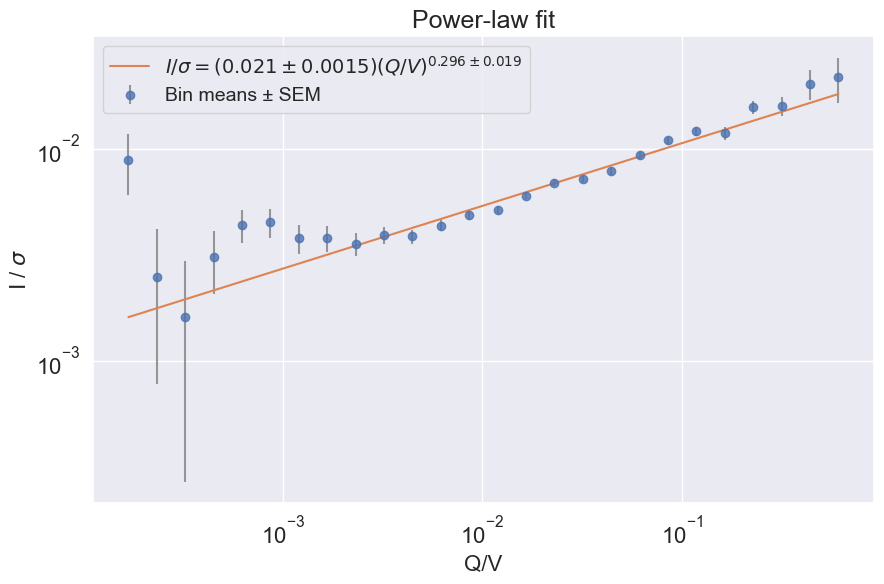

--- Overall (All) ---
Y = 0.020969 ± 0.00148
γ = 0.295599 ± 0.0187
R²_log = 0.9120 | R²_lin = 0.8682
Bins used: 26 (min_count ≥ 20)


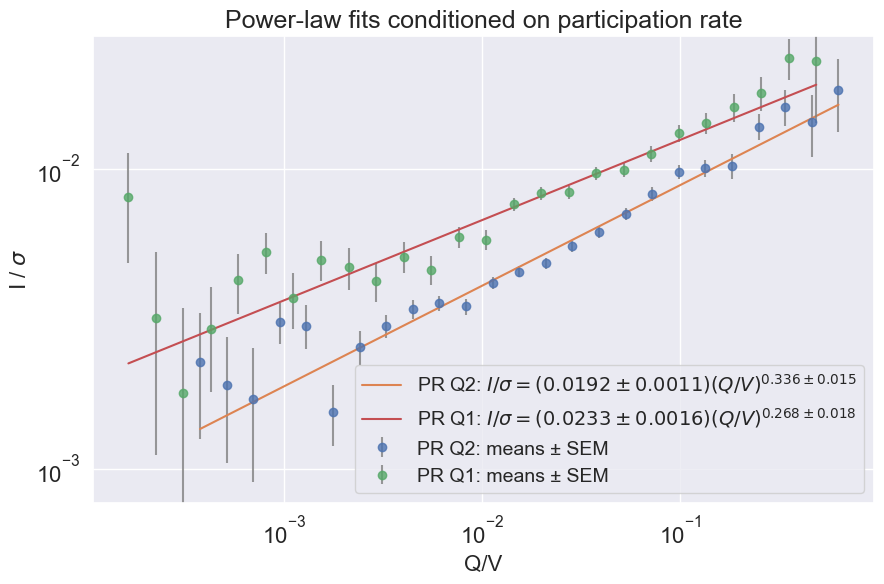

--- Conditioned on Participation Rate ---
[PR Q2]  Y = 0.0192098 ± 0.00113 | γ = 0.335993 ± 0.0153 |
[PR Q1]  Y = 0.0232646 ± 0.00158 | γ = 0.268005 ± 0.0176 |


In [23]:
# Prepare data
df = metaorders_info_df_sameday.copy()
df = df[df['Q/V'] > 1e-5]
df['Impact'] = df['Price Change'] * df['Direction'] / df['Daily Vol']
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=['Q/V', 'Impact'])
df = df[df['Q/V'] > 0]  # strictly positive for log space

# Font sizes
LABEL_SIZE = 16
LEGEND_SIZE = 14
TITLE_SIZE = 18

# (optional) set some global defaults to align with the parameters
plt.rcParams.update({
    "axes.labelsize": LABEL_SIZE,
    "axes.titlesize": TITLE_SIZE,
    "legend.fontsize": LEGEND_SIZE,
})

# ----------------------------
# Utilities
# ----------------------------
def power_law(qv, Y, gamma):
    """I/sigma = Y * (Q/V)^gamma"""
    return Y * np.power(qv, gamma)

def fit_power_law_logbins_wls(
    subdf: pd.DataFrame,
    n_logbins: int = 30,
    min_count: int = 100,        # reliability filter: keep only bins with enough obs
    use_median: bool = False     # set True for robustness; paper uses conditional averages (means)
):
    """
    Bin on a fixed log grid in Q/V, compute conditional mean Impact per bin,
    estimate Y, gamma in log–log space via weighted least squares:
        log(I) = log(Y) + gamma * log(Q/V)
    with weights w = 1 / Var[log(mean_imp)] ≈ (mean_imp / SEM)^2.

    Returns:
        binned_df: DataFrame with center_QV, mean_imp, sem_imp, count
        params   : (Y, Y_se, gamma, gamma_se, R2_log, R2_lin)
    """
    sub = subdf[(subdf['Q/V'] > 0) & np.isfinite(subdf['Impact'])].copy()
    if sub.empty:
        raise ValueError("No valid rows (Q/V>0 and finite Impact).")

    x = sub['Q/V'].to_numpy()
    y = sub['Impact'].to_numpy()

    # Fixed log grid on observed support
    x_min = x.min()
    x_max = x.max()
    if not np.isfinite(x_min) or not np.isfinite(x_max) or x_max <= x_min:
        raise ValueError("Invalid Q/V range for log binning.")
    edges = np.logspace(np.log10(x_min), np.log10(x_max), n_logbins + 1)

    # Assign bins
    bin_idx = np.digitize(x, edges) - 1
    mask = (bin_idx >= 0) & (bin_idx < n_logbins)
    x, y, bin_idx = x[mask], y[mask], bin_idx[mask]

    # --- Aggregate in each bin (robust to empty bins) ---
    dfb = pd.DataFrame({'x': x, 'y': y, 'bin': bin_idx})

    agg = (
        dfb.groupby('bin')['y']
           .agg(mean_imp='mean',
                median_imp='median',
                std_imp=lambda s: s.std(ddof=1),
                count='size')
           .sort_index()
    )

    # choose mean/median for the fit
    y_stat = agg['median_imp'] if use_median else agg['mean_imp']
    y_std  = agg['std_imp'].to_numpy()
    n      = agg['count'].to_numpy()
    sem    = y_std / np.sqrt(np.maximum(n, 1))

    # geometric centers for the *present* bins only
    bins_present = agg.index.to_numpy()
    left_edges   = edges[bins_present]
    right_edges  = edges[bins_present + 1]
    x_center     = np.sqrt(left_edges * right_edges)

    binned = pd.DataFrame({
        'center_QV': x_center,
        'mean_imp':  y_stat.to_numpy(),
        'std_imp':   y_std,
        'sem_imp':   sem,
        'count':     n
    }).sort_values('center_QV').reset_index(drop=True)

    # Reliability & positivity filters for log fit
    binned = binned[
        (binned['count'] >= min_count) &
        np.isfinite(binned['mean_imp']) &
        np.isfinite(binned['sem_imp']) &
        (binned['sem_imp'] > 0) &
        (binned['mean_imp'] > 0)
    ]
    if len(binned) < 3:
        raise ValueError(f"Not enough valid bins after filtering (got {len(binned)}). "
                         f"Try lowering min_count or n_logbins.")

    X = np.log(binned['center_QV'].to_numpy())
    Z = np.log(binned['mean_imp'].to_numpy())

    # Delta-method weights: Var[log(mean_imp)] ≈ (SEM/mean)^2  => w = 1/Var
    var_logy = (binned['sem_imp'].to_numpy() / binned['mean_imp'].to_numpy())**2
    w = 1.0 / var_logy
    w = np.where(np.isfinite(w) & (w > 0), w, 0)

    # Weighted least squares for Z = a + gamma * X  (Y = exp(a))
    A = np.vstack([np.ones_like(X), X]).T
    Aw = A * np.sqrt(w)[:, None]
    Zw = Z * np.sqrt(w)
    coef, _, _, _ = np.linalg.lstsq(Aw, Zw, rcond=None)
    a_hat, gamma_hat = coef
    Y_hat = np.exp(a_hat)

    # Covariance of coefficients: cov ≈ sigma^2 * (X' W X)^(-1), sigma^2 from weighted residuals
    res  = Z - (a_hat + gamma_hat * X)
    RSS  = np.sum(w * res**2)
    dof  = max(len(Z) - 2, 1)
    s2   = RSS / dof
    XtWX = A.T @ (w[:, None] * A)
    cov  = s2 * np.linalg.inv(XtWX)
    a_se, gamma_se = np.sqrt(np.diag(cov))
    Y_se = Y_hat * a_se  # delta-method

    # R^2 on log scale (weighted) and on original scale (unweighted, for intuition)
    Zhat = a_hat + gamma_hat * X
    Zbar = np.average(Z, weights=w)
    R2_log = 1.0 - np.sum(w * (Z - Zhat)**2) / np.sum(w * (Z - Zbar)**2)

    yhat   = power_law(binned['center_QV'].to_numpy(), Y_hat, gamma_hat)
    ybar   = np.mean(binned['mean_imp'].to_numpy())
    R2_lin = 1.0 - np.sum((binned['mean_imp'].to_numpy() - yhat)**2) / np.sum((binned['mean_imp'].to_numpy() - ybar)**2)

    return binned, (Y_hat, Y_se, gamma_hat, gamma_se, R2_log, R2_lin)

def plot_fit(ax, binned: pd.DataFrame, params, label_prefix=None,
             label_size: int = LABEL_SIZE, legend_size: int = LEGEND_SIZE):
    """Scatter with SEM bars and fitted curve on log–log axes."""
    Y, Y_err, gamma, gamma_err, R2_log, R2_lin = params

    ax.errorbar(
        binned['center_QV'],
        binned['mean_imp'],
        yerr=binned['sem_imp'],
        fmt='o', alpha=0.8, ecolor='gray',
        label='Bin means ± SEM' if label_prefix is None else f'{label_prefix}: means ± SEM'
    )

    x_min, x_max = binned['center_QV'].min(), binned['center_QV'].max()
    x_grid = np.logspace(np.log10(x_min), np.log10(x_max), 300)
    ax.plot(
        x_grid, power_law(x_grid, Y, gamma),
        label=(rf'{"" if label_prefix is None else label_prefix + ": "}'
               rf'$I/\sigma = ({Y:.3g}\pm{Y_err:.2g})(Q/V)^{{{gamma:.3f}\pm{gamma_err:.3f}}}$')
    )

    ax.set_xscale('log'); ax.set_yscale('log')
    ax.set_xlabel('Q/V', fontsize=label_size)
    ax.set_ylabel(r'I / $\sigma$', fontsize=label_size)
    ax.tick_params(axis='both', which='both', labelsize=label_size)
    ax.legend(loc='best', fontsize=legend_size)

# ----------------------------
# 1) Overall fit (all metaorders)
# ----------------------------
n_logbins = 30
min_count = 20  # raise for larger datasets; lower if data is sparse

binned_all, params_all = fit_power_law_logbins_wls(
    df, n_logbins=n_logbins, min_count=min_count, use_median=False
)

fig, ax = plt.subplots(figsize=(9, 6))
plot_fit(ax, binned_all, params_all)  # sizes are controlled by LABEL_SIZE/LEGEND_SIZE
ax.set_title('Power-law fit', fontsize=TITLE_SIZE)
plt.tight_layout()
plt.savefig(f'images/power_law_fit_overall_mot_{LEVEL}_prop.png', dpi=300)
plt.show()

print('--- Overall (All) ---')
print(f'Y = {params_all[0]:.6g} ± {params_all[1]:.3g}')
print(f'γ = {params_all[2]:.6f} ± {params_all[3]:.3g}')
print(f'R²_log = {params_all[4]:.4f} | R²_lin = {params_all[5]:.4f}')
print(f'Bins used: {len(binned_all)} (min_count ≥ {min_count})')

# ----------------------------
# 2) Conditioning on Participation Rate
# ----------------------------
PR_CANDIDATES = 'Participation Rate'

# Define participation-rate groups via quantiles (change nbins if needed)
pr_nbins = 2
labels = [f'Q{j+1}' for j in range(pr_nbins)]
df = df.copy()
df['PR_bin'] = pd.qcut(df[PR_CANDIDATES], q=pr_nbins, labels=labels, duplicates='drop')

# Fit and plot one curve per PR bin using the *same* WLS procedure
fig, ax = plt.subplots(figsize=(9, 6))
legend_entries = []
fits_by_pr = {}

for label in df['PR_bin'].dropna().unique():
    sub = df[df['PR_bin'] == label]
    try:
        binned_sub, params_sub = fit_power_law_logbins_wls(
            sub, n_logbins=n_logbins, min_count=min_count, use_median=False
        )
    except Exception as e:
        print(f"[{label}] skipped: {e}")
        continue

    plot_fit(ax, binned_sub, params_sub, label_prefix=f'PR {label}')
    fits_by_pr[str(label)] = params_sub

ax.set_title('Power-law fits conditioned on participation rate', fontsize=TITLE_SIZE)
plt.tight_layout()
plt.savefig(f'images/power_law_fits_by_participation_rate_mot_{LEVEL}_prop.png', dpi=300)
plt.show()

print('--- Conditioned on Participation Rate ---')
for k, (Y, Y_se, gamma, gamma_se, R2_log, R2_lin) in fits_by_pr.items():
    print(f"[PR {k}]  Y = {Y:.6g} ± {Y_se:.3g} | γ = {gamma:.6f} ± {gamma_se:.3g} |")
